Author: Jason Papale </br>
Last Updated: 04NOV2024

# Introduction

The purpose of this notebook is to train and evaluate several forecasting models to predict the future occupancy of parking lots given current occupancy, as well as other independent variables (e.g., day of week). I performed this modeling effort to help my friend Manos Chatzopoulos, CEO of [ParkZen](https://www.parkzenapp.com/), better leverage parking data available within his company.

# Imports

In [ ]:
%%capture
!pip install shap

In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import datetime

from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Activation
from tensorflow import keras
import tensorflow as tf
import shap

# Exploratory Data Analysis and Feature Engineering

In [ ]:
# Files used (or created) in this notebook can be found using the following google drive link
# https://drive.google.com/drive/folders/1B7d_Ihfr7O9gIseqPsGAHP1TW0byIQx6?usp=sharing

In [ ]:
# Reading in the Data
df = pd.read_csv('Touchdown Village West Lot X174.csv')

In [ ]:
# Reformatting Columns
df.columns = [x.strip().upper().replace(' ', '_') for x in df.columns]

In [ ]:
# Taking a look at shape of df and some records int the front and back of df
df

,TIME,PROJECTED_OCCUPANCY,NUM_PARKED_IOS,NUM_PARKED_ANDROID,NUM_PARKED
0,09/25 06:31 PM,4 %,1,0,1
1,09/25 08:04 PM,8 %,2,0,2
2,09/25 09:38 PM,4 %,1,0,1
3,09/26 06:22 AM,8 %,2,0,2
4,09/26 06:42 AM,12 %,3,0,3
...,...,...,...,...,...
5297,08/25 10:57 AM,9 %,1,0,1
5298,08/25 11:41 AM,27 %,3,0,3
5299,08/25 11:56 AM,18 %,2,0,2
5300,08/25 12:11 PM,18 %,2,0,2


In [ ]:
# Taking a look at column types
df.dtypes

TIME                   object
PROJECTED_OCCUPANCY    object
NUM_PARKED_IOS          int64
NUM_PARKED_ANDROID      int64
NUM_PARKED              int64
dtype: object

In [ ]:
# Adding year to the timestamp
df['TIME'] = df['TIME'].apply(lambda x: x[0:5] + '/2022' + x[5:])

In [ ]:
# Changing TIME field to datetime
df['TIME'] = pd.to_datetime(df['TIME'], format='%m/%d/%Y %I:%M %p')

In [ ]:
# Getting first record in January so we can know when to increment the year to 2023 (works because we know the dataset only spans two partial years and starts in 2022)
IDX_OF_FIRST_RECORD_IN_2023 = df[df['TIME'].dt.month == 1].index.min()

In [ ]:
# Incrementing the year for the appropriate records to 2023
df.loc[IDX_OF_FIRST_RECORD_IN_2023:,'TIME'] = df['TIME'] + pd.offsets.DateOffset(years=1)

In [ ]:
# Changing PROJECTED_OCCUPANCY field to float and in decimal format
df['PROJECTED_OCCUPANCY'] = (df['PROJECTED_OCCUPANCY'].str[:-2]).astype('float')/100

In [ ]:
# Taking a look at our updated df
df

,TIME,PROJECTED_OCCUPANCY,NUM_PARKED_IOS,NUM_PARKED_ANDROID,NUM_PARKED
0,2022-09-25 18:31:00,0.04,1,0,1
1,2022-09-25 20:04:00,0.08,2,0,2
2,2022-09-25 21:38:00,0.04,1,0,1
3,2022-09-26 06:22:00,0.08,2,0,2
4,2022-09-26 06:42:00,0.12,3,0,3
...,...,...,...,...,...
5297,2023-08-25 10:57:00,0.09,1,0,1
5298,2023-08-25 11:41:00,0.27,3,0,3
5299,2023-08-25 11:56:00,0.18,2,0,2
5300,2023-08-25 12:11:00,0.18,2,0,2


In [ ]:
# Getting summary statistics
df.describe()

,PROJECTED_OCCUPANCY,NUM_PARKED_IOS,NUM_PARKED_ANDROID,NUM_PARKED
count,5302.000000,5302.000000,5302.0,5302.000000
mean,0.433859,8.584874,0.0,8.584874
std,0.222864,5.935631,0.0,5.935631
min,0.000000,0.000000,0.0,0.000000
25%,0.270000,4.000000,0.0,4.000000
50%,0.430000,7.000000,0.0,7.000000
75%,0.600000,13.000000,0.0,13.000000
max,1.230000,32.000000,0.0,32.000000


In [ ]:
# Removing NUM_PARKED_ANDROID column since there are no values other than 0 there
df.drop(columns = ['NUM_PARKED_ANDROID', 'NUM_PARKED_IOS'], inplace=True)

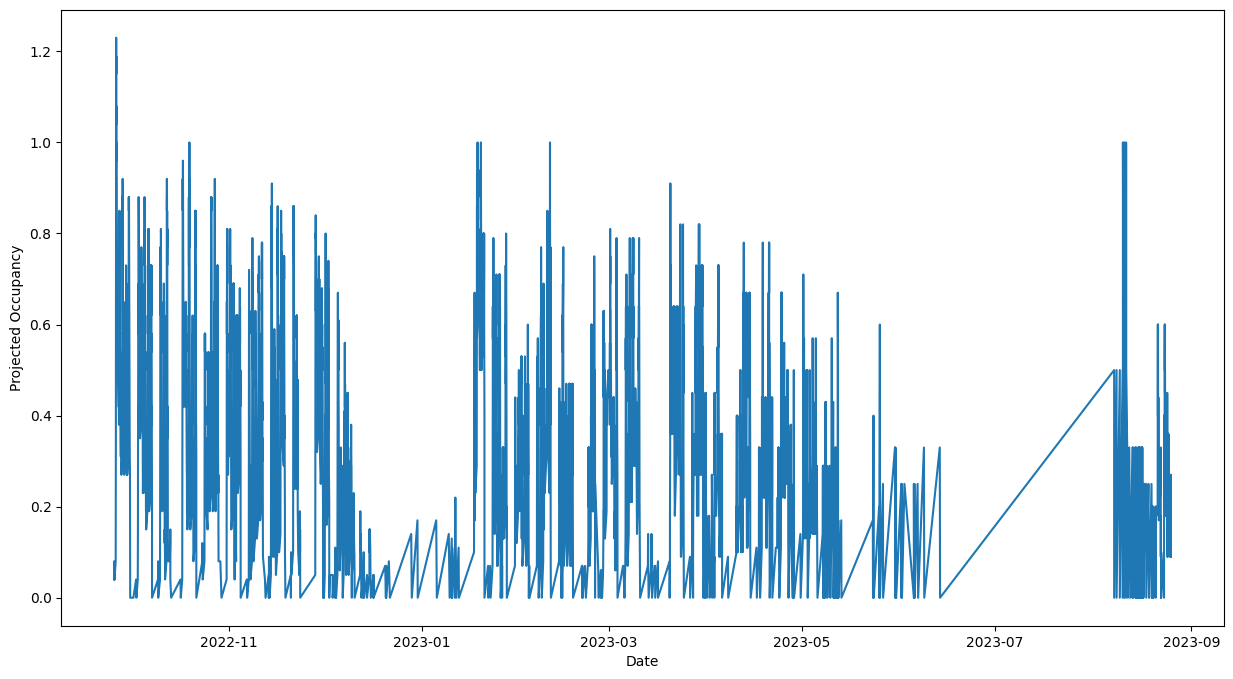

In [ ]:
# Taking a look at Projected Occupancy over Time
fig, ax = plt.subplots(figsize=(15,8))

ax.plot(df['TIME'], df['PROJECTED_OCCUPANCY'])

ax.set_xlabel('Date')
ax.set_ylabel('Projected Occupancy')
plt.show()

# Transforming Dataset to Consist of 15-Minute Intervals

In [ ]:
# Making Date/Time Lookup Table with 15 minute increments
DATES = pd.date_range('2022-09-26', periods=365)

In [ ]:
# Creating a list which combines each date with four 15 minute intervals for each hour in the day
DATETIMES = []
for i in DATES:
  for j in range(int(60*24/15)):
    DATETIMES.append(i + pd.Timedelta(minutes=15+(j*15)))

In [ ]:
# Creating a dataframe from the list created in the cell above.  Then applying the shift method to create an interval_end field (so that for each
# row in the df we can have an interval begin and interval end).
datetimes_df = pd.DataFrame(DATETIMES, columns = ['INTERVAL_BEGIN'])
datetimes_df['INTERVAL_END'] =  datetimes_df['INTERVAL_BEGIN'].shift(-1)
datetimes_df

,INTERVAL_BEGIN,INTERVAL_END
0,2022-09-26 00:15:00,2022-09-26 00:30:00
1,2022-09-26 00:30:00,2022-09-26 00:45:00
2,2022-09-26 00:45:00,2022-09-26 01:00:00
3,2022-09-26 01:00:00,2022-09-26 01:15:00
4,2022-09-26 01:15:00,2022-09-26 01:30:00
...,...,...
35035,2023-09-25 23:00:00,2023-09-25 23:15:00
35036,2023-09-25 23:15:00,2023-09-25 23:30:00
35037,2023-09-25 23:30:00,2023-09-25 23:45:00
35038,2023-09-25 23:45:00,2023-09-26 00:00:00


In [ ]:
# Pushing tables into SQLite environment
conn = sqlite3.connect(':memory:')
df.to_sql('df', conn, if_exists='replace', index=False)
datetimes_df.to_sql('datetimes_df', conn, if_exists='replace', index=False)

In [ ]:
query = '''

/*With this initial subqeury, we use the datetimes_df table as our main table (1 row per unique 15 minute interval) and left join our parking
data (1 row per change in lot occupancy).  This ensures will enable us to build a more consistent perspective on lot occupancy with respect
to time (instead of jumping from timestamp to timestamp).  Within each interval, we will then sequence any parking timestamps that fall within
that interval by the timestamp but in descending order (such that the latest parking timestamp will have the row number = 1).*/

WITH INITIAL AS

(
SELECT
  t1.INTERVAL_BEGIN
  ,t1.INTERVAL_END
  ,t2.TIME
  ,t2.PROJECTED_OCCUPANCY
  ,t2.NUM_PARKED
  ,t2.DAY_OF_WEEK
  ,t2.PROJECTED_OCCUPANCY
  ,ROW_NUMBER() OVER (PARTITION BY t1.INTERVAL_END ORDER BY t2.TIME DESC) AS ROW_NUM_REVERSE

FROM datetimes_df t1

LEFT JOIN df t2
  ON  t2.time >= t1.INTERVAL_BEGIN
  AND t2.time < t1.INTERVAL_END

)



/*With this subquery, we pull forward the results from our initial subquery but only keep intervals where there was at least one parking
timestamp which joined into the interavl.  If multiple timestamps joined, we will keep the latest one (i.e., the one where ROW_NUM_REVERSE = 1).
The purpose of doing this is so when we join to this this table using the results from our initial table (which we'll do next), we can find, for
any intervals where there is not parking timestamp data, the most recent interaval where there is parking timestamp data.*/

, FLATTENING AS

(
SELECT
  INTERVAL_BEGIN
  ,INTERVAL_END
  ,DAY_OF_WEEK
  ,TIME
  ,NUM_PARKED ASLAST_NUM_PARKED_IN_INTERVAL
  ,PROJECTED_OCCUPANCY AS LAST_PROJECTED_OCCUPANCY_IN_INTERVAL

FROM INITIAL

WHERE
  ROW_NUM_REVERSE = 1
  AND DAY_OF_WEEK IS NOT NULL

)




/*With this subquery, we take the results from our INITIAL subquery (one row per interval, expanded for each timestamp that joins to an interval)
and left join to the results of the FLATTENING subquery (one row per interval where at least one parking timstamp joined) and, for each interval
in the INITIAL table where no parking timestamps joined, we will bring in all of the intervals from the FLATTENING table which precede said interval.
Following the join, for each interval in the INITIAL table, we then sequence all of the intervals which joined from the FLATTENING table by order
of the parking timestamp (there will only be one parking timestamp per interval from the FLATTENING table) in descending order.  We do this, so
that in the next (and final) query, we can reference, for each interval where there was not parking timestamp data, the most recently available
parking timestamp data (which should still be an accurate reflection of lot occupancy).  We also join into the FLATTENING table again, but this time,
we join in the interval_end time and only for records where the interval was able to join on parking timestamp data.  This allows us to bring in,
for each interval (expanded by parking timestamp data) the record associated with the last parking timestamp for each interval.  This, in turn,
allows us to keep all of the parking timestamps while also keeping, for each interval, the latest parking timestamp available.  Since each interval
record from the INITIAL table will join to the FLATTENING table via one (and only one) of the two joins, we coalesce the last_projected_occupancy_in_interval
field.*/

, EXPLODE AS

(

SELECT
  t1.INTERVAL_BEGIN
  ,t1.INTERVAL_END
  ,t1.TIME
  ,t1.PROJECTED_OCCUPANCY
  ,t1.NUM_PARKED
  ,t1.DAY_OF_WEEK
  ,ROW_NUM_REVERSE
  ,COALESCE(t2.LAST_PROJECTED_OCCUPANCY_IN_INTERVAL, t3.LAST_PROJECTED_OCCUPANCY_IN_INTERVAL) AS LAST_PROJECTED_OCCUPANCY_IN_INTERVAL
  ,ROW_NUMBER() OVER (PARTITION BY t1.INTERVAL_END ORDER BY t2.TIME DESC) AS ROW_NUM

FROM INITIAL t1

LEFT JOIN FLATTENING t2
  ON  t2.INTERVAL_END < t1.INTERVAL_END
  AND t1.DAY_OF_WEEK IS NULL

LEFT JOIN FLATTENING t3
  ON  t3.INTERVAL_END = t1.INTERVAL_END
  AND t1.DAY_OF_WEEK IS NOT NULL

)




/*With this final query we take the output from the EXPLODE subquery and flatten it by simply removing the parking timestamp records which joined to
the interval records (as part of the FLATTENING t2 join) but which weren't the most recently available timestamp.  We do this by only keeping records
where ROW_NUM = 1 (which drops timestamp records which aren't the most recent) or t1.TIME IS NOT NULL (which keeps the interval records for which
there was at least 1 timestamp records which joined in the INITIAL subquery)*/

SELECT
  DISTINCT
  t1.INTERVAL_BEGIN
  ,t1.INTERVAL_END
  ,t1.TIME
  ,t1.PROJECTED_OCCUPANCY
  ,t1.NUM_PARKED
  ,t1.DAY_OF_WEEK
  ,ROW_NUM_REVERSE
  ,t1.LAST_PROJECTED_OCCUPANCY_IN_INTERVAL

FROM EXPLODE t1

WHERE ROW_NUM = 1 OR t1.TIME IS NOT NULL

ORDER BY  t1.INTERVAL_END, t1.TIME

'''

result_df = pd.read_sql_query(query, conn)

In [ ]:
# Converting INTERVAL_BEGIN and INTERVAL_END to datetime
result_df['INTERVAL_BEGIN'] = pd.to_datetime(result_df['INTERVAL_BEGIN'])
result_df['INTERVAL_END'] = pd.to_datetime(result_df['INTERVAL_END'])

In [ ]:
# Taking a look at a few initial records
result_df.sort_values('INTERVAL_BEGIN').head()

,INTERVAL_BEGIN,INTERVAL_END,TIME,PROJECTED_OCCUPANCY,NUM_PARKED,DAY_OF_WEEK,ROW_NUM_REVERSE,LAST_PROJECTED_OCCUPANCY_IN_INTERVAL
1,2022-09-26 00:15:00,2022-09-26 00:30:00,None,NaN,NaN,None,1,NaN
2,2022-09-26 00:30:00,2022-09-26 00:45:00,None,NaN,NaN,None,1,NaN
3,2022-09-26 00:45:00,2022-09-26 01:00:00,None,NaN,NaN,None,1,NaN
4,2022-09-26 01:00:00,2022-09-26 01:15:00,None,NaN,NaN,None,1,NaN
5,2022-09-26 01:15:00,2022-09-26 01:30:00,None,NaN,NaN,None,1,NaN


In [ ]:
# Number of records in dataframe
len(result_df)

36925

# Checkpoint - Begin

In [ ]:
# Saving Interval Dataframe
result_df.to_csv('INTERVAL_PARKZEN_DATA.csv', index=False)

In [ ]:
# Reading Interval Dataframe back in
result_df = pd.read_csv('INTERVAL_PARKZEN_DATA.csv')

# Checkpoint - End

In [ ]:
# Converting INTERVAL_BEGIN and INTERVAL_END to datetime (in case reading in from CSV doesn't parse correctly)
result_df['INTERVAL_BEGIN'] = pd.to_datetime(result_df['INTERVAL_BEGIN'])
result_df['INTERVAL_END'] = pd.to_datetime(result_df['INTERVAL_END'])

In [ ]:
# Only keeping 1 record per interval (keeping the one with the latest/most recent occupancy data available)
df_trimmed = result_df[result_df['ROW_NUM_REVERSE'] == 1].copy()

In [ ]:
# Removing data associated with the Christmas break and after Summer started (there's no point including that in modeling since we only have one school year of good data)
# That is, the max timeframe where we have numerous cyclical observations is at the weekly level

# Per LSU 2022-2023 Academic Calendar:
# Last Day of Fall Classes -> 12/3 (going to 12/4 to end on Sunday)
# First Day of Spring Classes -> 1/17 (going to 1/16 to be a Monday (even though MLK day))
# Last Day of Spring Classes -> 5/6

df_trimmed = df_trimmed[(df_trimmed['INTERVAL_BEGIN'] >= '2022-09-27') & (df_trimmed['INTERVAL_BEGIN'] <= '2022-12-04') | (('2023-01-17' <= df_trimmed['INTERVAL_BEGIN']) & ('2023-05-06' >= df_trimmed['INTERVAL_BEGIN']))].copy()

In [ ]:
# Creating a field which pulls in the prior record's occupancy field
df_trimmed['LAST_PROJECTED_OCCUPANCY_IN_INTERVAL_PREVIOUS_INTERVAL'] = df_trimmed['LAST_PROJECTED_OCCUPANCY_IN_INTERVAL'].shift(1)

In [ ]:
# Creating a field which calculates the change in occupancy from one interval to the next
df_trimmed['CHANGE_IN_PROJECTED_OCCUPANCY'] = df_trimmed['LAST_PROJECTED_OCCUPANCY_IN_INTERVAL'] - df_trimmed['LAST_PROJECTED_OCCUPANCY_IN_INTERVAL_PREVIOUS_INTERVAL']

In [ ]:
# Extracting Day of Week from Date
df_trimmed['DAY_OF_WEEK'] = df_trimmed['INTERVAL_BEGIN'].dt.day_name()

In [ ]:
# Creating a field which contains the number of hours and minutes associated with the timestamp
df_trimmed['HOUR'] = df_trimmed['INTERVAL_BEGIN'].dt.hour
df_trimmed['MINUTES'] = df_trimmed['INTERVAL_BEGIN'].dt.minute

In [ ]:
# Creating a field which represents the total number of minutes (to enable a way to represent time of day as a continuous variable)
df_trimmed['TOTAL_MINUTES'] = (df_trimmed['HOUR']*60) + df_trimmed['MINUTES']

In [ ]:
# Scaling variables that we'll potentially use in modeling (which aren't already constrained to range of 0 to 1) to a range of 0 to 1
scaler = MinMaxScaler()
df_trimmed['TOTAL_MINUTES_SCALED'] = scaler.fit_transform(np.array(df_trimmed['TOTAL_MINUTES']).reshape(-1, 1) )
df_trimmed['NUM_PARKED_SCALED'] = scaler.fit_transform(np.array(df_trimmed['NUM_PARKED']).reshape(-1, 1) )
df_trimmed['CHANGE_IN_PROJECTED_OCCUPANCY_SCALED'] = scaler.fit_transform(np.array(df_trimmed['CHANGE_IN_PROJECTED_OCCUPANCY']).reshape(-1, 1) )

In [ ]:
# Adding binary flags for day of week
df_trimmed = pd.concat([df_trimmed, pd.get_dummies(df_trimmed['DAY_OF_WEEK'])], axis=1)

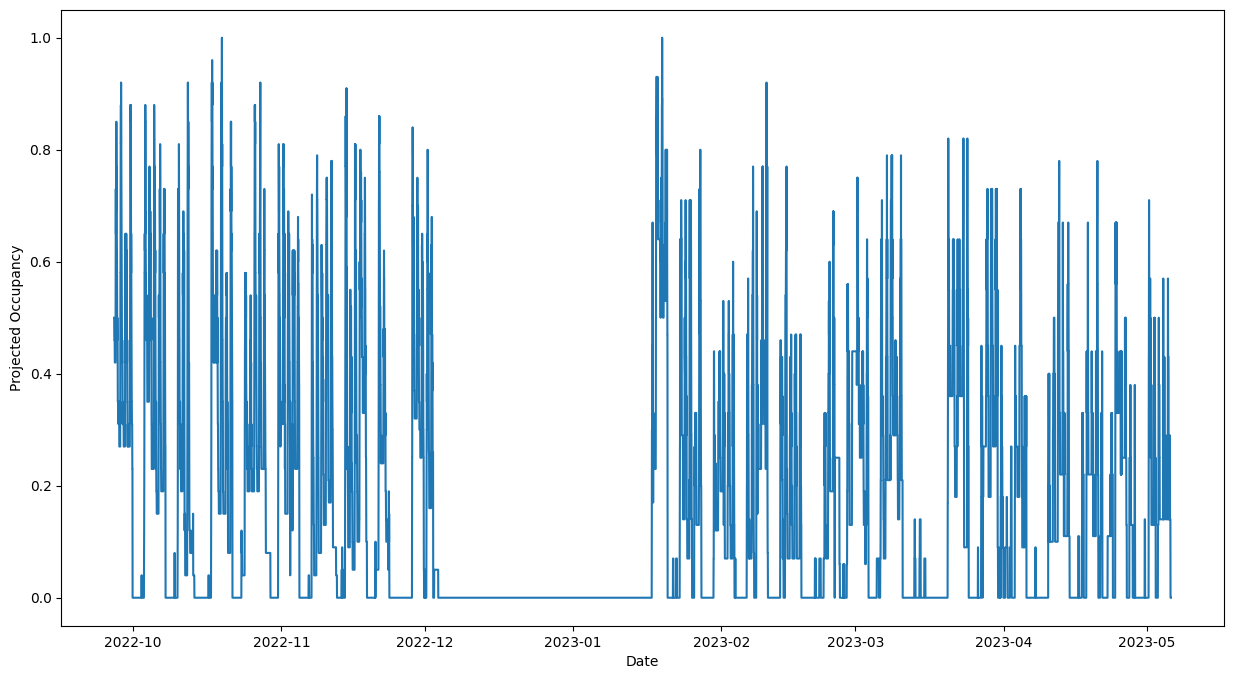

In [ ]:
# Looking at our trimmed df
fig, ax = plt.subplots(figsize=(15,8))

ax.plot(df_trimmed['INTERVAL_BEGIN'], df_trimmed['LAST_PROJECTED_OCCUPANCY_IN_INTERVAL'])

ax.set_xlabel('Date')
ax.set_ylabel('Projected Occupancy')
plt.show()

# Modeling

## Facebook Prophet - Univariate Forecasting Model

In [ ]:
# https://facebook.github.io/prophet/docs/quick_start.html

In [ ]:
# Creating a separate df which contains the two fields necessary for the the prophet model (a field which delineates the sequence and the IV)
model_df = df_trimmed[['INTERVAL_BEGIN','LAST_PROJECTED_OCCUPANCY_IN_INTERVAL']].copy()

In [ ]:
# prepare expected column names
model_df.columns = ['ds', 'y']

In [ ]:
# Splitting dataset into train and test
Train = model_df[model_df['ds'] <= '2022-12-04']
Test = model_df[model_df['ds'] >= '2023-01-17']

In [ ]:
# Creating and training model
model = Prophet()
model.fit(Train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi5i36fh2/q7json9n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi5i36fh2/2tnsirwk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2098', 'data', 'file=/tmp/tmpi5i36fh2/q7json9n.json', 'init=/tmp/tmpi5i36fh2/2tnsirwk.json', 'output', 'file=/tmp/tmpi5i36fh2/prophet_modelmcct0kv2/prophet_model-20231004033926.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:39:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:39:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Generating forecast and combining it with actual values.  Also replacing any predicted values that are < 0 with 0
forecast = model.predict(pd.DataFrame(Test['ds']))[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
forecast = pd.concat([forecast, Test['y'].reset_index(drop=True)], axis=1)
forecast['yhat'] = forecast['yhat'].apply(lambda x: 0 if x < 0 else x)

In [ ]:
# Creating absolute error field (between forecast and actuals)
forecast['ABSOLUTE_ERROR'] = np.abs(forecast['yhat'] - forecast['y'])

In [ ]:
# Taking a look at some records
forecast.head()

,ds,yhat,yhat_lower,yhat_upper,y,ABSOLUTE_ERROR
0,2023-01-17 00:00:00,0.334650,0.138304,0.519616,0.0,0.334650
1,2023-01-17 00:15:00,0.335119,0.144443,0.530412,0.0,0.335119
2,2023-01-17 00:30:00,0.336306,0.153902,0.534700,0.0,0.336306
3,2023-01-17 00:45:00,0.338115,0.138980,0.525020,0.0,0.338115
4,2023-01-17 01:00:00,0.340390,0.161495,0.530091,0.0,0.340390


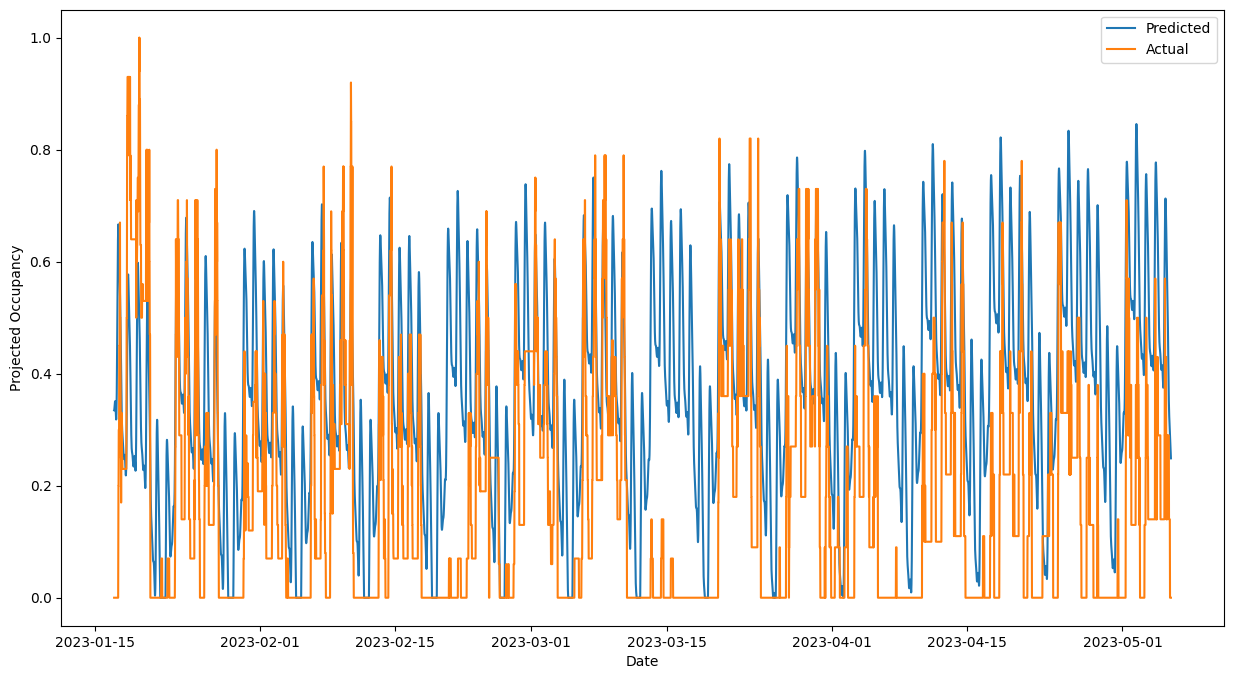

In [ ]:
# Taking a looking at actual vs predicted for our test data
fig, ax = plt.subplots(figsize=(15,8))

ax.plot(forecast['ds'], forecast[['yhat', 'y']], label=['Predicted','Actual'])

ax.set_xlabel('Date')
ax.set_ylabel('Projected Occupancy')
ax.legend()
plt.show()

In [ ]:
# Error Metrics
print('MAE of Model:')
forecast['ABSOLUTE_ERROR'].mean()

MAE of Model:


0.22654873616864715

## Multi-Step Multi-Variate LSTM

With this model, we will look at more than just occupancy as an IV and predict multiple timesteps in the future.  We also have the option of defining how many observations we want to look at when making a prediction.  For this run, we'll choose 30 observations (i.e., intervals) and predict the next 8 intervals.

In [ ]:
# https://pangkh98.medium.com/multi-step-multivariate-time-series-forecasting-using-lstm-92c6d22cd9c2

In [ ]:
# Creating a field which gets the occupancy for the next interval
df_trimmed['LABEL'] = df_trimmed['LAST_PROJECTED_OCCUPANCY_IN_INTERVAL'].shift(-1)

In [ ]:
# Selecting the variables (IVs and DV) we'll use in the model
lstm_model_df = df_trimmed[['LAST_PROJECTED_OCCUPANCY_IN_INTERVAL', 'CHANGE_IN_PROJECTED_OCCUPANCY', 'Friday',	'Monday',
                       'Saturday',	'Sunday',	'Thursday',	'Tuesday', 'Wednesday', 'TOTAL_MINUTES_SCALED', 'LABEL']].iloc[1:-1,].copy()

In [ ]:
# Converting Pandas Dataframe to Numpy array
dataset_stacked = np.array(lstm_model_df)

In [ ]:
# Checking shape of array
dataset_stacked.shape

(16992, 11)

In [ ]:
# Using a function I found from the link above which prepares the dataset in the way that is needed for modeling.

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
 X, y = list(), list()
 for i in range(len(sequences)):
  # find the end of this pattern
  end_ix = i + n_steps_in
  out_end_ix = end_ix + n_steps_out-1
  # check if we are beyond the dataset
  if out_end_ix > len(sequences):
   break
  # gather input and output parts of the pattern
  # Specifically, seq_x is a 2D array with number of rows = n_steps_in and contains all the IVs.
  # seq_y is a 1D array which contains the label associated with the current 2D array, as well as the subsequent ones for a total of n_steps_out
  seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
  X.append(seq_x)
  y.append(seq_y)
 return np.array(X), np.array(y)
# choose a number of time steps #change this accordingly
n_steps_in, n_steps_out = 30 , 8
# covert into input/output
X, y = split_sequences(dataset_stacked, n_steps_in, n_steps_out)
print ("X.shape" , X.shape)
print ("y.shape" , y.shape)

X.shape (16956, 30, 10)
y.shape (16956, 8)


In [ ]:
# Creating 2 split points: 1 to split training from dev and one to split dev from test
train_dev_split_point = int(X.shape[0] * .75)
dev_test_split_point = int(X.shape[0] * .8)
train_X , train_y = X[:train_dev_split_point, :] , y[:train_dev_split_point, :]
dev_X, dev_y = X[train_dev_split_point:dev_test_split_point, :] , y[train_dev_split_point:dev_test_split_point, :]
test_X , test_y = X[dev_test_split_point:, :] , y[dev_test_split_point:, :]

In [ ]:
# Taking a look at the shape of some of our datasets
print(train_X.shape)
print(test_X.shape)

(12717, 30, 10)
(3392, 30, 10)


In [ ]:
# Setting variables for model construction
n_features = train_X.shape[2]
n_steps_in = 30
n_steps_out = 8

In [ ]:
#optimizer learning rate
opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
# define model
lstm_model = tf.keras.models.Sequential()
lstm_model.add(tf.keras.layers.LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
lstm_model.add(tf.keras.layers.LSTM(50, activation='relu'))
lstm_model.add(tf.keras.layers.Dense(n_steps_out))
lstm_model.add(tf.keras.layers.Activation('linear'))
lstm_model.compile(loss=tf.keras.losses.mse , optimizer=opt , metrics=['mse'])

In [ ]:
# Fit network (Trained using T4 GPU)
history = lstm_model.fit(train_X , train_y , epochs=60 , steps_per_epoch=25 , verbose=1 , validation_data=(dev_X, dev_y) ,shuffle=False)

Epoch 1/60
25/25 [==============================] - 7s 127ms/step - loss: 0.0794 - mse: 0.0794 - val_loss: 0.0618 - val_mse: 0.0618
Epoch 2/60
25/25 [==============================] - 3s 115ms/step - loss: 0.0473 - mse: 0.0473 - val_loss: 0.0402 - val_mse: 0.0402
Epoch 3/60
25/25 [==============================] - 3s 117ms/step - loss: 0.0321 - mse: 0.0321 - val_loss: 0.0286 - val_mse: 0.0286
Epoch 4/60
25/25 [==============================] - 6s 231ms/step - loss: 0.0225 - mse: 0.0225 - val_loss: 0.0218 - val_mse: 0.0218
Epoch 5/60
25/25 [==============================] - 6s 251ms/step - loss: 0.0182 - mse: 0.0182 - val_loss: 0.0193 - val_mse: 0.0193
Epoch 6/60
25/25 [==============================] - 3s 135ms/step - loss: 0.0157 - mse: 0.0157 - val_loss: 0.0180 - val_mse: 0.0180
Epoch 7/60
25/25 [==============================] - 7s 266ms/step - loss: 0.0146 - mse: 0.0146 - val_loss: 0.0184 - val_mse: 0.0184
Epoch 8/60
25/25 [==============================] - 7s 277ms/step - loss: 0.

# Checkpoint - Begin

In [ ]:
# Saving LSTM model weights
lstm_model.save_weights('LSTM_MODEL_WEIGHTS')

In [ ]:
# Loading LSTM model weights
lstm_model.load_weights('LSTM_MODEL_WEIGHTS')

# Checkpoint - End

In [ ]:
# Generating predictions for test dataset
y_pred = lstm_model.predict(test_X)

106/106 [==============================] - 1s 11ms/step


In [ ]:
# replacing any predictions that are < 0 with 0
y_pred = np.clip(y_pred, 0, None)

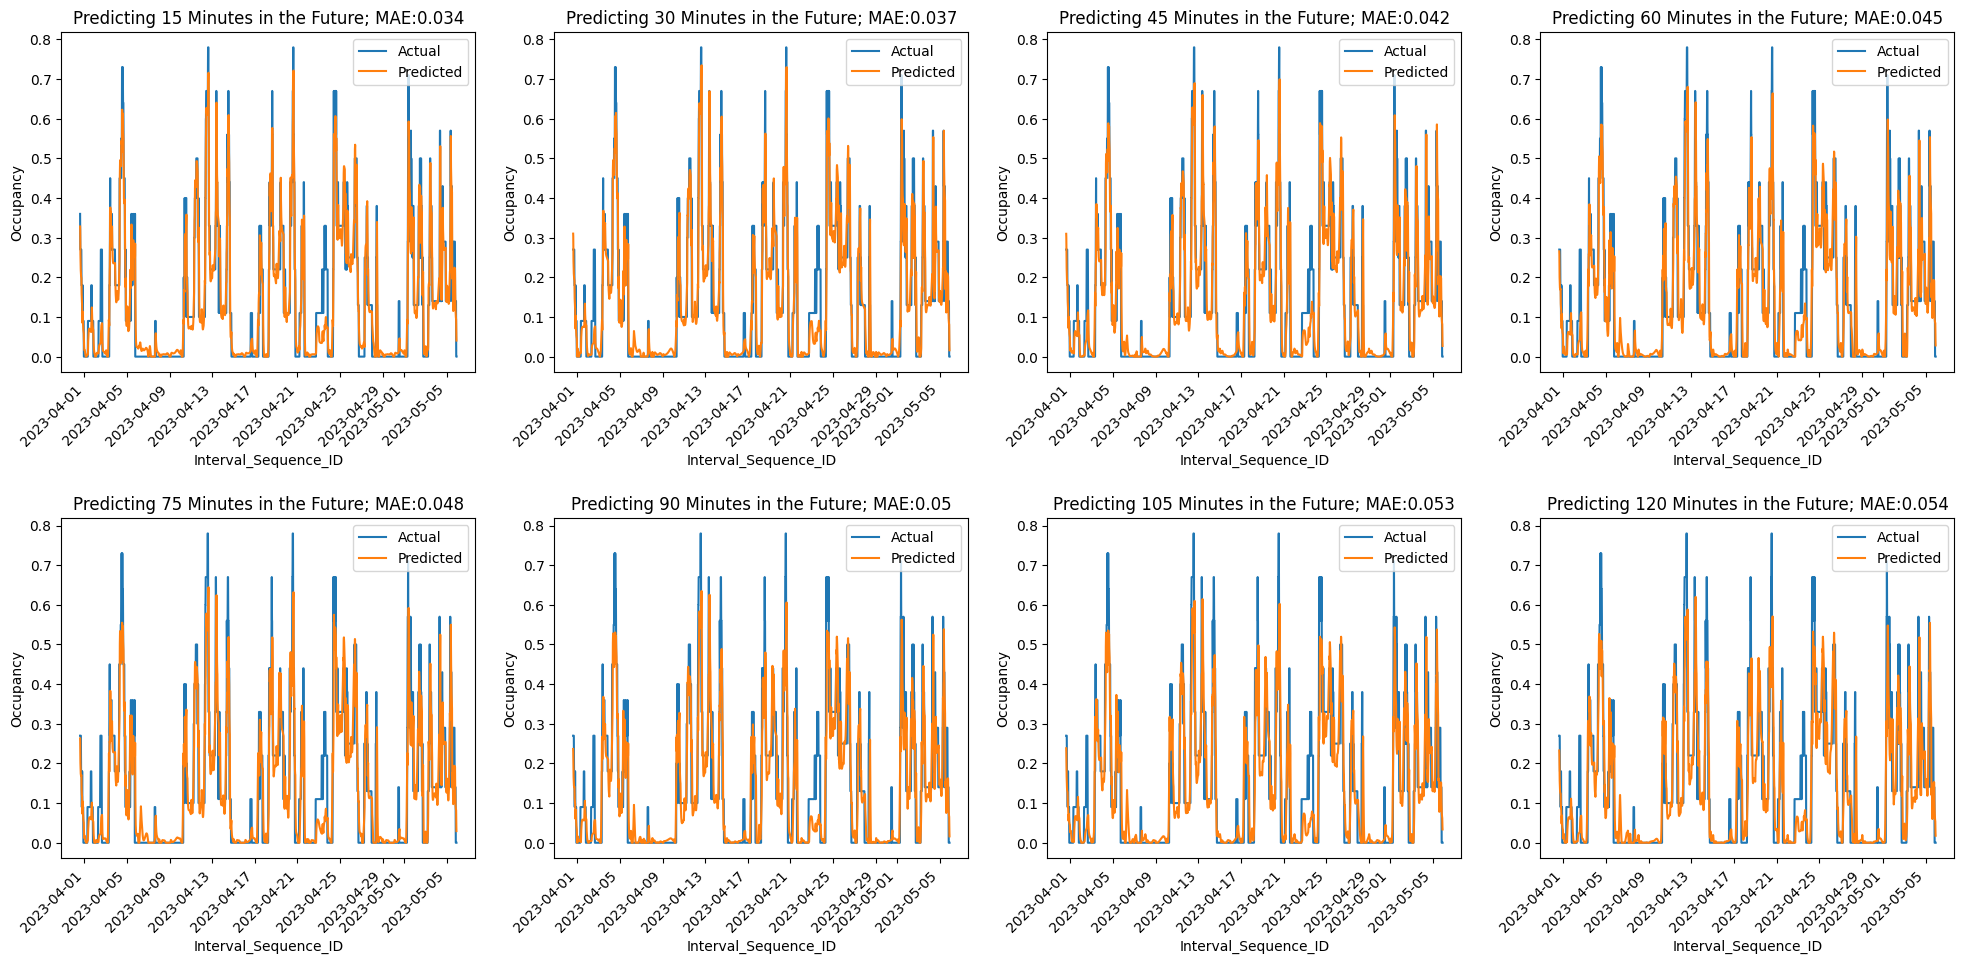

In [ ]:
# Plotting results for each prediction time horizon with associated MAE value

fig = plt.figure(1, figsize=(20,10))

Tot = test_y.shape[1]
Cols = 4

# Compute Rows required
Rows = Tot // Cols
Rows += Tot % Cols

Position = range(1,Tot + 1)

for i in range(Tot):

  # add every single subplot to the figure with a for loop
  ax = fig.add_subplot(Rows,Cols,Position[i])
  plot_df = pd.DataFrame(pd.concat([pd.Series(test_y[:,i]), pd.Series(y_pred[:,i])], axis=1   )).reset_index(drop=True)
  plot_df.columns = ['Actual','Predicted']
  plot_df.set_index(df_trimmed.loc[lstm_model_df.iloc[-test_y.shape[0]-7:-7, :].index]['INTERVAL_END'], inplace=True)
  errors = plot_df['Actual'] - plot_df['Predicted']
  mae = np.abs(errors).mean()
  plot = ax.plot(plot_df, label=['Actual','Predicted'])
  ax.set_title('Predicting '+str((i+1)*15)+' Minutes in the Future; MAE:{}'.format(round(mae, 3)))
  ax.set_xlabel('Interval_Sequence_ID')
  ax.set_ylabel('Occupancy')
  ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
  ax.legend()
fig.tight_layout(pad=2)
plt.show()



## Shapley Values

In [ ]:
# https://towardsdatascience.com/multivariate-time-series-forecasting-with-deep-learning-3e7b3e2d2bcf

In [ ]:
# integrate out feature importances based on background dataset
e = shap.GradientExplainer(lstm_model, train_X[np.random.choice(train_X.shape[0], 1000, replace=False)])

In [ ]:
shap_values_ = e.shap_values(test_X[0:100])

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [ ]:
# # explain the model's outputs on some data samples
# shap_values = e.shap_values()
# shap_values = np.absolute(shap_values_)
# shap_values = np.mean(shap_values, axis=0)

In [ ]:
shap_abs = np.absolute(shap_values_)
sum_0 = np.sum(shap_abs,axis=0)
shap_values = np.mean(sum_0, axis=0)

In [ ]:
shap_plot = pd.DataFrame(shap_values, columns=lstm_model_df.iloc[:,:-1].columns.tolist())
shap_plot.columns = [x.upper() for x in shap_plot.columns]
shap_plot['TIMESTEP'] = [i-31 for i in list(range(1,31))]
shap_plot.head()

,LAST_PROJECTED_OCCUPANCY_IN_INTERVAL,CHANGE_IN_PROJECTED_OCCUPANCY,FRIDAY,MONDAY,SATURDAY,SUNDAY,THURSDAY,TUESDAY,WEDNESDAY,TOTAL_MINUTES_SCALED,TIMESTEP
0,0.000453,0.000197,0.003035,0.000350,0.000660,0.000420,0.000598,0.000967,0.000473,0.003079,-30
1,0.000561,0.000223,0.003311,0.000390,0.000723,0.000531,0.000764,0.001031,0.000532,0.003572,-29
2,0.000683,0.000275,0.003625,0.000444,0.000784,0.000548,0.000897,0.001086,0.000610,0.004049,-28
3,0.000795,0.000288,0.003942,0.000465,0.000866,0.000589,0.001082,0.001142,0.000690,0.004509,-27
4,0.000905,0.000350,0.004288,0.000518,0.000966,0.000616,0.001291,0.001209,0.000773,0.004973,-26


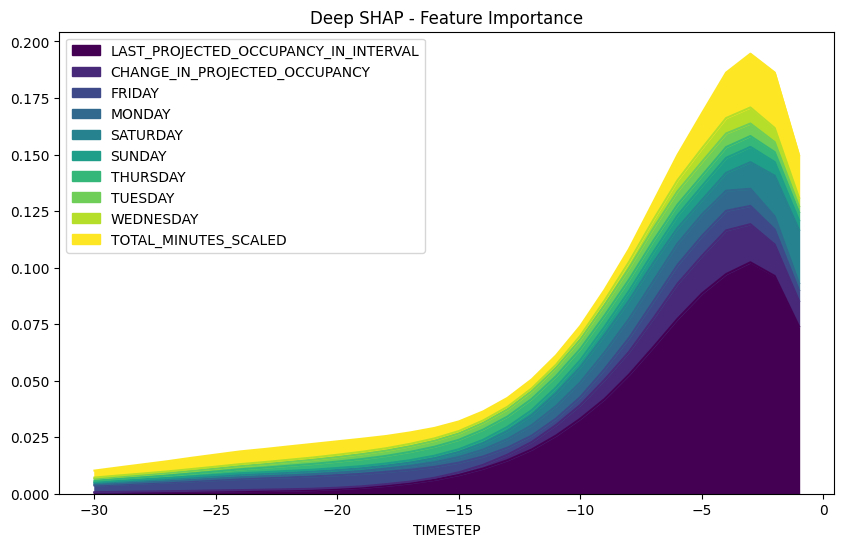

In [ ]:
shap_plot.plot.area(x='TIMESTEP', figsize=(10, 6), cmap='viridis')
plt.title("Deep SHAP - Feature Importance")
plt.show()